# Data Question 3

## Exploring earthquake data

### Nate Silver discusses the difficulty of predicting earthquakes in The Signal and the Noise, but are there factors that make an earthquake more likely?
Are there factors that make an earthquake more deadly?
Where would you live if you wanted to eliminate the risk of experiencing an earthquake?
Where would you avoid living?

## Data cleaning tasks include:
1. Replace empty strings with NaN
2. Remove the footnotes from the 'Other Source Deaths' column
3. Convert Magnitude to a numeric
4. Create a new column ('deaths') that evaluates the four total-death columns ('PDE Total Deaths', 'Utsu Total Deaths', 'EM-DAT Total Deaths', and 'Other Source Deaths') and populates the new column with the highest value.
5. Explore the data in terms of when and where earthquakes occurred and how severe they were (magnitude, deaths, secondary effects).

In [357]:
import pandas as pd
import requests
from bs4 import BeautifulSoup as BS
import numpy as np
import re
import requests
import folium
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
from folium.plugins import HeatMap
from folium.plugins import HeatMapWithTime

%matplotlib inline
# Increasing default figure size of the notebook
plt.rcParams['figure.figsize'] = [12, 8]

In [250]:
# URL for Wikipedia article with earthquake data table
url = 'http://en.wikipedia.org/wiki/List_of_deadly_earthquakes_since_1900'

In [251]:
# create a Request object for the wikipedia page for the Turing Award
response = requests.get(url)

# read the resulting HTML into a variable called result_text
result_text = response.text

In [252]:
# create the soup by constructing a BS object from the html page and the appropriate parser
soup = BS(result_text, 'html.parser')
#soup

In [253]:
# Find table from web page
# There is only one table on the wikipedia page
table = soup.find_all('table', attrs = {'class':'sortable wikitable'})
#table

In [254]:
table;

In [255]:
table_rows = table[0].findAll('tr')
table_rows;

In [256]:
data = []
for ind, tr in enumerate(table_rows):
    tag = 'td' if ind else 'th'
    row = [elem.text for elem in tr.findAll(tag)]
    data.append(row)
earthquakes_df = pd.DataFrame(data[1:], columns=data[0])
earthquakes_df.head()

,Origin (UTC),Present-day country and link to Wikipedia article,Lat,Long,Depth (km),Magnitude,Secondary Effects,PDE Shaking Deaths,PDE Total Deaths,Utsu Total Deaths,EM-DAT Total Deaths,Other Source Deaths
0,1900-05-11 17:23,Japan,38.700,141.100,5,7.0 MJMA,,,,,,\n
1,1900-07-12 06:25,Turkey,40.300,43.100,,5.9 Muk,,,,140,,\n
2,1900-10-29 09:11,Venezuela,11.000,-66.000,0,7.7 Mw,,,,,,\n
3,1901-02-15 00:00,China,26.000,100.100,0,6.5 Ms,,,,,,\n
4,1901-03-31 07:11,Bulgaria,43.400,28.700,,6.4 Muk,,,,4,,\n


### Secondary effects are reported, they are indicated by “T”, “L”, “F” or “Lq”
T = Tsunami,
L = Landslide,
F = Fire,
Lq = Liquefaction

In [257]:
earthquakes_df = earthquakes_df.replace('\n', '')
earthquakes_df = earthquakes_df.replace("", np.nan)
earthquakes_df

,Origin (UTC),Present-day country and link to Wikipedia article,Lat,Long,Depth (km),Magnitude,Secondary Effects,PDE Shaking Deaths,PDE Total Deaths,Utsu Total Deaths,EM-DAT Total Deaths,Other Source Deaths
0,1900-05-11 17:23,Japan,38.700,141.100,5,7.0 MJMA,NaN,NaN,NaN,NaN,NaN,NaN
1,1900-07-12 06:25,Turkey,40.300,43.100,NaN,5.9 Muk,NaN,NaN,NaN,140,NaN,NaN
2,1900-10-29 09:11,Venezuela,11.000,-66.000,0,7.7 Mw,NaN,NaN,NaN,NaN,NaN,NaN
3,1901-02-15 00:00,China,26.000,100.100,0,6.5 Ms,NaN,NaN,NaN,NaN,NaN,NaN
4,1901-03-31 07:11,Bulgaria,43.400,28.700,NaN,6.4 Muk,NaN,NaN,NaN,4,NaN,NaN
5,1901-08-09 09:23,Japan,40.500,142.500,35,7.2 Mw,T,NaN,NaN,NaN,NaN,NaN
6,1901-11-15 20:15,New Zealand (see 1901 Cheviot earthquake),-43.000,173.000,0,6.8 Ms,NaN,NaN,NaN,1,NaN,NaN
7,1902-01-30 14:01,Japan,40.500,141.300,35,6.9 Ms,NaN,NaN,NaN,1,NaN,NaN
8,1902-02-13 09:39,Azerbaijan,40.700,48.600,15,6.9 Muk,NaN,NaN,NaN,86,NaN,NaN
9,1902-03-09 07:46,Turkey,40.700,33.600,NaN,5.5 Muk,NaN,NaN,NaN,4,NaN,NaN


In [258]:
# Creating new DF for the clean data
# Changing columns to make them easier to call
clean_df = earthquakes_df
clean_df.columns = ['origin', 'country', 'lat', 'long', 'depth_km', 'magnitude', 'secondary_effects', 
                 'pde_shaking', 'pde_total', 'utsu_total', 'em_dat_total', 'other_source']

clean_df.head()

,origin,country,lat,long,depth_km,magnitude,secondary_effects,pde_shaking,pde_total,utsu_total,em_dat_total,other_source
0,1900-05-11 17:23,Japan,38.700,141.100,5,7.0 MJMA,NaN,NaN,NaN,NaN,NaN,NaN
1,1900-07-12 06:25,Turkey,40.300,43.100,NaN,5.9 Muk,NaN,NaN,NaN,140,NaN,NaN
2,1900-10-29 09:11,Venezuela,11.000,-66.000,0,7.7 Mw,NaN,NaN,NaN,NaN,NaN,NaN
3,1901-02-15 00:00,China,26.000,100.100,0,6.5 Ms,NaN,NaN,NaN,NaN,NaN,NaN
4,1901-03-31 07:11,Bulgaria,43.400,28.700,NaN,6.4 Muk,NaN,NaN,NaN,4,NaN,NaN


In [259]:
clean_df.tail()

,origin,country,lat,long,depth_km,magnitude,secondary_effects,pde_shaking,pde_total,utsu_total,em_dat_total,other_source
1335,2011-03-11 14:46,Japan (see 2011 Tōhoku earthquake),38.322,142.369,24.4,9.0 Mw,T,NaN,NaN,NaN,NaN,15894[20]\n
1336,2011-03-24 20:25,Burma (see 2011 Burma earthquake),NaN,NaN,NaN,6.8 Mw,NaN,NaN,NaN,NaN,NaN,150+\n
1337,2011-04-07 14:32,Japan (see April 2011 Miyagi earthquake),38.2,140.0,66.0,7.1 Mw,NaN,NaN,NaN,NaN,NaN,NaN
1338,2011-09-18 12:40,India (see 2011 Sikkim earthquake),27.723,88.064,19.7,6.9 Mw,L,NaN,NaN,NaN,NaN,111+\n
1339,2011-09-23 10:41,Turkey (see 2011 Van earthquake),38.6,43.5,7.2,7.1 Mw,NaN,NaN,NaN,NaN,NaN,"601 (as of October 30, 2011)\n"


In [260]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1340 entries, 0 to 1339
Data columns (total 12 columns):
origin               1340 non-null object
country              1340 non-null object
lat                  1326 non-null object
long                 1326 non-null object
depth_km             1250 non-null object
magnitude            1339 non-null object
secondary_effects    373 non-null object
pde_shaking          739 non-null object
pde_total            750 non-null object
utsu_total           1027 non-null object
em_dat_total         560 non-null object
other_source         37 non-null object
dtypes: object(12)
memory usage: 125.7+ KB


In [261]:
#clean_df.loc[:,['secondary_effects', 'pde_shaking', 'pde_total', 'utsu_total', 'em_dat_total', 'other_source']] = clean_df.loc[:,['secondary_effects', 'pde_shaking', 'pde_total', 'utsu_total', 'em_dat_total', 'other_source']].fillna(0)
clean_df.tail()

,origin,country,lat,long,depth_km,magnitude,secondary_effects,pde_shaking,pde_total,utsu_total,em_dat_total,other_source
1335,2011-03-11 14:46,Japan (see 2011 Tōhoku earthquake),38.322,142.369,24.4,9.0 Mw,T,NaN,NaN,NaN,NaN,15894[20]\n
1336,2011-03-24 20:25,Burma (see 2011 Burma earthquake),NaN,NaN,NaN,6.8 Mw,NaN,NaN,NaN,NaN,NaN,150+\n
1337,2011-04-07 14:32,Japan (see April 2011 Miyagi earthquake),38.2,140.0,66.0,7.1 Mw,NaN,NaN,NaN,NaN,NaN,NaN
1338,2011-09-18 12:40,India (see 2011 Sikkim earthquake),27.723,88.064,19.7,6.9 Mw,L,NaN,NaN,NaN,NaN,111+\n
1339,2011-09-23 10:41,Turkey (see 2011 Van earthquake),38.6,43.5,7.2,7.1 Mw,NaN,NaN,NaN,NaN,NaN,"601 (as of October 30, 2011)\n"


In [262]:
# Cleaning up other_source column
# Removing \n
# removing footnotes
# removing +
# removing parentheses
clean_df.loc[clean_df['other_source'].str.contains('\n').fillna(False),'other_source']= clean_df[clean_df['other_source'].str.contains('\n').fillna(False)].loc[:,'other_source'].str[:-1] #= clean_df['other_source'].str[:-2]
clean_df.tail()

,origin,country,lat,long,depth_km,magnitude,secondary_effects,pde_shaking,pde_total,utsu_total,em_dat_total,other_source
1335,2011-03-11 14:46,Japan (see 2011 Tōhoku earthquake),38.322,142.369,24.4,9.0 Mw,T,NaN,NaN,NaN,NaN,15894[20]
1336,2011-03-24 20:25,Burma (see 2011 Burma earthquake),NaN,NaN,NaN,6.8 Mw,NaN,NaN,NaN,NaN,NaN,150+
1337,2011-04-07 14:32,Japan (see April 2011 Miyagi earthquake),38.2,140.0,66.0,7.1 Mw,NaN,NaN,NaN,NaN,NaN,NaN
1338,2011-09-18 12:40,India (see 2011 Sikkim earthquake),27.723,88.064,19.7,6.9 Mw,L,NaN,NaN,NaN,NaN,111+
1339,2011-09-23 10:41,Turkey (see 2011 Van earthquake),38.6,43.5,7.2,7.1 Mw,NaN,NaN,NaN,NaN,NaN,"601 (as of October 30, 2011)"


In [263]:
for row in range(clean_df.shape[0]):
    df_str = clean_df.loc[row, 'other_source']
    if type(df_str) == str:
        if df_str.isdigit() == True:
            clean_df.loc[row, 'other_source'] = df_str
        else:
            count = 0
            while df_str[count].isdigit() or df_str[count] == ',':
                count+=1
                if count == len(df_str):
                    break
            df_str = df_str[:count]
            clean_df.loc[row, 'other_source'] = df_str
        
clean_df.tail(10)

,origin,country,lat,long,depth_km,magnitude,secondary_effects,pde_shaking,pde_total,utsu_total,em_dat_total,other_source
1330,2010-03-08 02:32,Turkey (see 2010 Elâzığ earthquake),NaN,NaN,NaN,6.1 Mw,NaN,NaN,NaN,NaN,NaN,42
1331,2010-03-11 14:39,Chile (see 2010 Pichilemu earthquake),NaN,NaN,NaN,6.9 Mw,L,NaN,NaN,NaN,NaN,1
1332,2010-04-14 23:49,China (see 2010 Yushu earthquake),NaN,NaN,NaN,6.9 Mw,L,NaN,NaN,NaN,NaN,"2,698"
1333,2011-02-21 23:51,New Zealand (see 2011 Christchurch earthquake),NaN,NaN,NaN,6.3 Mw,Lq,NaN,NaN,NaN,NaN,181
1334,2011-03-10 04:58,China (see 2011 Yunnan earthquake),NaN,NaN,NaN,5.4 Mw,NaN,NaN,NaN,NaN,NaN,NaN
1335,2011-03-11 14:46,Japan (see 2011 Tōhoku earthquake),38.322,142.369,24.4,9.0 Mw,T,NaN,NaN,NaN,NaN,15894
1336,2011-03-24 20:25,Burma (see 2011 Burma earthquake),NaN,NaN,NaN,6.8 Mw,NaN,NaN,NaN,NaN,NaN,150
1337,2011-04-07 14:32,Japan (see April 2011 Miyagi earthquake),38.2,140.0,66.0,7.1 Mw,NaN,NaN,NaN,NaN,NaN,NaN
1338,2011-09-18 12:40,India (see 2011 Sikkim earthquake),27.723,88.064,19.7,6.9 Mw,L,NaN,NaN,NaN,NaN,111
1339,2011-09-23 10:41,Turkey (see 2011 Van earthquake),38.6,43.5,7.2,7.1 Mw,NaN,NaN,NaN,NaN,NaN,601


In [264]:
clean_df['other_source'].unique()

array([nan, '3500', '8000', '46', '164', '1500', '105000', '1404', '1',
       '120', '200', None, '380', '2041', '33', '45000', '2489', '26271',
       '68', '231000', '41', '60', '215', '34', '295', '79', '189',
       '1,115', '222,517', '521', '42', '2,698', '181', '15894', '150',
       '111', '601'], dtype=object)

In [265]:
clean_df['other_source'].replace(regex=True,inplace=True,to_replace=r'\,', value='')
clean_df['other_source'].unique()

array([nan, '3500', '8000', '46', '164', '1500', '105000', '1404', '1',
       '120', '200', None, '380', '2041', '33', '45000', '2489', '26271',
       '68', '231000', '41', '60', '215', '34', '295', '79', '189',
       '1115', '222517', '521', '42', '2698', '181', '15894', '150',
       '111', '601'], dtype=object)

In [266]:
clean_df.magnitude = clean_df.magnitude.str.replace('5 ML', '5.0 ML') #correction for non-decimal entry
clean_df.magnitude = clean_df.magnitude.str.extract('(\d+\.\d+)')
clean_df['magnitude'] = pd.to_numeric(clean_df.magnitude)
clean_df['magnitude'].unique()

array([7. , 5.9, 7.7, 6.5, 6.4, 7.2, 6.8, 6.9, 5.5, 7.5, 6.7, 6. , 5.7,
       5.8, 8.3, 6.2, 6.3, 7.8, 6.6, 8.8, 7.1, 8.2, 7.9, 7.3, 7.6, 8.1,
       4.9, 7.4, 8.6, nan, 8.7, 8.5, 5.3, 5. , 5.4, 5.6, 6.1, 8.4, 4.8,
       8. , 9. , 9.5, 9.2, 5.2, 5.1, 4.3, 4.6, 4.2, 4.5, 4.7, 4.4, 3.5,
       2.3, 3.4, 2.8, 2. , 2.6, 3.8, 4. , 2.7, 9.1, 2.2])

In [267]:
# Looking at entry with ? in some of the columns
clean_df.iloc[413,:]

origin                                     1963-06-26 04:17
country              Macedonia (see 1963 Skopje earthquake)
lat                                                       ?
long                                                     ??
depth_km                                                  ?
magnitude                                               6.1
secondary_effects                                       NaN
pde_shaking                                             NaN
pde_total                                              1100
utsu_total                                              NaN
em_dat_total                                            NaN
other_source                                           None
Name: 413, dtype: object

In [268]:
# Fixing bad entry that previously had ?
clean_df.iloc[413,2:5] = np.nan
clean_df.iloc[413,:]

origin                                     1963-06-26 04:17
country              Macedonia (see 1963 Skopje earthquake)
lat                                                     NaN
long                                                    NaN
depth_km                                                NaN
magnitude                                               6.1
secondary_effects                                       NaN
pde_shaking                                             NaN
pde_total                                              1100
utsu_total                                              NaN
em_dat_total                                            NaN
other_source                                           None
Name: 413, dtype: object

In [269]:
# Fill death columns with 0 instead of NaN
# clean_df[['pde_shaking', 'pde_total', 'utsu_total', 'em_dat_total']] = clean_df[['pde_shaking', 'pde_total', 'utsu_total', 'em_dat_total']].fillna(value=0)


In [270]:
# Converting relevant columns to numeric
clean_df['pde_shaking'] = pd.to_numeric(clean_df['pde_shaking'])
clean_df['pde_total'] = pd.to_numeric(clean_df['pde_total'])
clean_df['utsu_total'] = pd.to_numeric(clean_df['utsu_total'])
clean_df.em_dat_total = clean_df.em_dat_total.str.extract('(\d+)')
clean_df['em_dat_total'] = pd.to_numeric(clean_df['em_dat_total'])
clean_df['lat'] = pd.to_numeric(clean_df['lat'])
clean_df['long'] = pd.to_numeric(clean_df['long'])

clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1340 entries, 0 to 1339
Data columns (total 12 columns):
origin               1340 non-null object
country              1340 non-null object
lat                  1325 non-null float64
long                 1325 non-null float64
depth_km             1249 non-null object
magnitude            1339 non-null float64
secondary_effects    373 non-null object
pde_shaking          739 non-null float64
pde_total            750 non-null float64
utsu_total           1027 non-null float64
em_dat_total         560 non-null float64
other_source         37 non-null object
dtypes: float64(7), object(5)
memory usage: 125.7+ KB


In [271]:
clean_df.head(10)

,origin,country,lat,long,depth_km,magnitude,secondary_effects,pde_shaking,pde_total,utsu_total,em_dat_total,other_source
0,1900-05-11 17:23,Japan,38.7,141.1,5,7.0,NaN,NaN,NaN,NaN,NaN,NaN
1,1900-07-12 06:25,Turkey,40.3,43.1,NaN,5.9,NaN,NaN,NaN,140.0,NaN,NaN
2,1900-10-29 09:11,Venezuela,11.0,-66.0,0,7.7,NaN,NaN,NaN,NaN,NaN,NaN
3,1901-02-15 00:00,China,26.0,100.1,0,6.5,NaN,NaN,NaN,NaN,NaN,NaN
4,1901-03-31 07:11,Bulgaria,43.4,28.7,NaN,6.4,NaN,NaN,NaN,4.0,NaN,NaN
5,1901-08-09 09:23,Japan,40.5,142.5,35,7.2,T,NaN,NaN,NaN,NaN,NaN
6,1901-11-15 20:15,New Zealand (see 1901 Cheviot earthquake),-43.0,173.0,0,6.8,NaN,NaN,NaN,1.0,NaN,NaN
7,1902-01-30 14:01,Japan,40.5,141.3,35,6.9,NaN,NaN,NaN,1.0,NaN,NaN
8,1902-02-13 09:39,Azerbaijan,40.7,48.6,15,6.9,NaN,NaN,NaN,86.0,NaN,NaN
9,1902-03-09 07:46,Turkey,40.7,33.6,NaN,5.5,NaN,NaN,NaN,4.0,NaN,NaN


In [272]:
# New column with highest value from all the death columns
clean_df['deaths'] = clean_df[['pde_total','utsu_total','em_dat_total', 'other_source']].max(axis=1)

clean_df.head(10)

,origin,country,lat,long,depth_km,magnitude,secondary_effects,pde_shaking,pde_total,utsu_total,em_dat_total,other_source,deaths
0,1900-05-11 17:23,Japan,38.7,141.1,5,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1900-07-12 06:25,Turkey,40.3,43.1,NaN,5.9,NaN,NaN,NaN,140.0,NaN,NaN,140.0
2,1900-10-29 09:11,Venezuela,11.0,-66.0,0,7.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1901-02-15 00:00,China,26.0,100.1,0,6.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1901-03-31 07:11,Bulgaria,43.4,28.7,NaN,6.4,NaN,NaN,NaN,4.0,NaN,NaN,4.0
5,1901-08-09 09:23,Japan,40.5,142.5,35,7.2,T,NaN,NaN,NaN,NaN,NaN,NaN
6,1901-11-15 20:15,New Zealand (see 1901 Cheviot earthquake),-43.0,173.0,0,6.8,NaN,NaN,NaN,1.0,NaN,NaN,1.0
7,1902-01-30 14:01,Japan,40.5,141.3,35,6.9,NaN,NaN,NaN,1.0,NaN,NaN,1.0
8,1902-02-13 09:39,Azerbaijan,40.7,48.6,15,6.9,NaN,NaN,NaN,86.0,NaN,NaN,86.0
9,1902-03-09 07:46,Turkey,40.7,33.6,NaN,5.5,NaN,NaN,NaN,4.0,NaN,NaN,4.0


In [273]:
# Convert Origin to datetime
clean_df['origin'] = pd.to_datetime(clean_df['origin'])
clean_df.head()

,origin,country,lat,long,depth_km,magnitude,secondary_effects,pde_shaking,pde_total,utsu_total,em_dat_total,other_source,deaths
0,1900-05-11 17:23:00,Japan,38.7,141.1,5,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1900-07-12 06:25:00,Turkey,40.3,43.1,NaN,5.9,NaN,NaN,NaN,140.0,NaN,NaN,140.0
2,1900-10-29 09:11:00,Venezuela,11.0,-66.0,0,7.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1901-02-15 00:00:00,China,26.0,100.1,0,6.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1901-03-31 07:11:00,Bulgaria,43.4,28.7,NaN,6.4,NaN,NaN,NaN,4.0,NaN,NaN,4.0


In [274]:
# Get rid of parentheticals following some of the country names
# clean_df.country = clean_df.country.str.extract('(\S+)')
# clean_df.head(15)

In [275]:
# Turning Latitude and Longitude to plottable points
clean_df['geometry'] = clean_df.apply(lambda x: Point((float(x.long), float(x.lat))), axis=1)
clean_df.head(10)

,origin,country,lat,long,depth_km,magnitude,secondary_effects,pde_shaking,pde_total,utsu_total,em_dat_total,other_source,deaths,geometry
0,1900-05-11 17:23:00,Japan,38.7,141.1,5,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (141.1 38.7)
1,1900-07-12 06:25:00,Turkey,40.3,43.1,NaN,5.9,NaN,NaN,NaN,140.0,NaN,NaN,140.0,POINT (43.1 40.3)
2,1900-10-29 09:11:00,Venezuela,11.0,-66.0,0,7.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-66 11)
3,1901-02-15 00:00:00,China,26.0,100.1,0,6.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (100.1 26)
4,1901-03-31 07:11:00,Bulgaria,43.4,28.7,NaN,6.4,NaN,NaN,NaN,4.0,NaN,NaN,4.0,POINT (28.7 43.4)
5,1901-08-09 09:23:00,Japan,40.5,142.5,35,7.2,T,NaN,NaN,NaN,NaN,NaN,NaN,POINT (142.5 40.5)
6,1901-11-15 20:15:00,New Zealand (see 1901 Cheviot earthquake),-43.0,173.0,0,6.8,NaN,NaN,NaN,1.0,NaN,NaN,1.0,POINT (173 -43)
7,1902-01-30 14:01:00,Japan,40.5,141.3,35,6.9,NaN,NaN,NaN,1.0,NaN,NaN,1.0,POINT (141.3 40.5)
8,1902-02-13 09:39:00,Azerbaijan,40.7,48.6,15,6.9,NaN,NaN,NaN,86.0,NaN,NaN,86.0,POINT (48.6 40.7)
9,1902-03-09 07:46:00,Turkey,40.7,33.6,NaN,5.5,NaN,NaN,NaN,4.0,NaN,NaN,4.0,POINT (33.6 40.7)


In [276]:
# Removing information in parentheses after the country names
clean_df['country']  = clean_df['country'].str.replace(r"\(.*\)","")
# Strip whitespace because a whitespace is left at the end of strings when the parentheses are removed
clean_df['country']  = clean_df['country'].str.strip()

clean_df.head(10)

,origin,country,lat,long,depth_km,magnitude,secondary_effects,pde_shaking,pde_total,utsu_total,em_dat_total,other_source,deaths,geometry
0,1900-05-11 17:23:00,Japan,38.7,141.1,5,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (141.1 38.7)
1,1900-07-12 06:25:00,Turkey,40.3,43.1,NaN,5.9,NaN,NaN,NaN,140.0,NaN,NaN,140.0,POINT (43.1 40.3)
2,1900-10-29 09:11:00,Venezuela,11.0,-66.0,0,7.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-66 11)
3,1901-02-15 00:00:00,China,26.0,100.1,0,6.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (100.1 26)
4,1901-03-31 07:11:00,Bulgaria,43.4,28.7,NaN,6.4,NaN,NaN,NaN,4.0,NaN,NaN,4.0,POINT (28.7 43.4)
5,1901-08-09 09:23:00,Japan,40.5,142.5,35,7.2,T,NaN,NaN,NaN,NaN,NaN,NaN,POINT (142.5 40.5)
6,1901-11-15 20:15:00,New Zealand,-43.0,173.0,0,6.8,NaN,NaN,NaN,1.0,NaN,NaN,1.0,POINT (173 -43)
7,1902-01-30 14:01:00,Japan,40.5,141.3,35,6.9,NaN,NaN,NaN,1.0,NaN,NaN,1.0,POINT (141.3 40.5)
8,1902-02-13 09:39:00,Azerbaijan,40.7,48.6,15,6.9,NaN,NaN,NaN,86.0,NaN,NaN,86.0,POINT (48.6 40.7)
9,1902-03-09 07:46:00,Turkey,40.7,33.6,NaN,5.5,NaN,NaN,NaN,4.0,NaN,NaN,4.0,POINT (33.6 40.7)


In [277]:
# Grouping by country and counting to see the countries which have the most earthquakes
eq_count = clean_df[['country', 'origin']].groupby(by = 'country').agg('count').sort_values(by ='origin', ascending = False)
eq_count = eq_count.reset_index()
eq_count.columns = ['country', 'count']
eq_count.head(10)


,country,count
0,China,166
1,Indonesia,96
2,Turkey,95
3,Iran,91
4,Japan,82
5,Peru,54
6,Taiwan,47
7,Mexico,46
8,Chile,44
9,Greece,44


### China has the most deadly earthquakes since 1900, but it's also a very large country. It's followed by Indonesia which is a much smaller country

In [278]:
eq_count.loc[eq_count['country'] == 'United States']

,country,count
12,United States,34


In [279]:
# Creating a new DF with a datetime index for date based analysis
eq_date_ind = clean_df
eq_date_ind = eq_date_ind.set_index('origin')
eq_date_ind.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1340 entries, 1900-05-11 17:23:00 to 2011-09-23 10:41:00
Data columns (total 13 columns):
country              1340 non-null object
lat                  1325 non-null float64
long                 1325 non-null float64
depth_km             1249 non-null object
magnitude            1339 non-null float64
secondary_effects    373 non-null object
pde_shaking          739 non-null float64
pde_total            750 non-null float64
utsu_total           1027 non-null float64
em_dat_total         560 non-null float64
other_source         37 non-null object
deaths               1245 non-null float64
geometry             1340 non-null object
dtypes: float64(8), object(5)
memory usage: 146.6+ KB


In [280]:
# Creating a new dataframe with the number of deadly earthquakes each year
eq_yearly = eq_date_ind['country'].resample('Y').agg('count')
eq_yearly = pd.DataFrame(eq_yearly)
eq_yearly.columns = ['count']
#eq_yearly = eq_yearly.reset_index()
eq_yearly['count'] = pd.to_numeric(eq_yearly['count'])
eq_yearly.head(15)

,count
origin,
1900-12-31,3
1901-12-31,4
1902-12-31,8
1903-12-31,5
1904-12-31,4
1905-12-31,5
1906-12-31,6
1907-12-31,5
1908-12-31,2


In [281]:
eq_yearly.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 112 entries, 1900-12-31 to 2011-12-31
Freq: A-DEC
Data columns (total 1 columns):
count    112 non-null int64
dtypes: int64(1)
memory usage: 1.8 KB


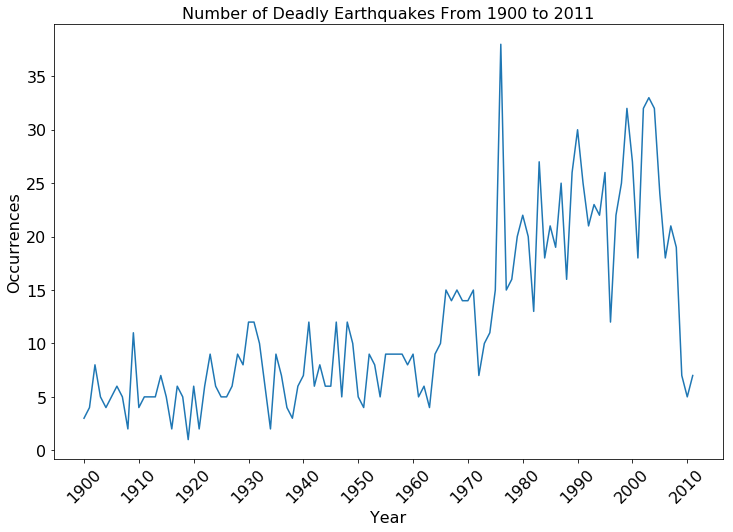

In [282]:
freq = eq_yearly['count']
plt.plot(freq)
dates = freq.index[::10]
labels = dates.strftime('%Y')
plt.xticks(dates, labels, rotation=45, fontsize = 16)
plt.yticks(fontsize = 16)
plt.title('Number of Deadly Earthquakes From 1900 to 2011', fontsize = 16)
plt.xlabel('Year', fontsize = 16)
plt.ylabel('Occurrences', fontsize = 16);

## Examine earthquakes by month to see if that yields anything interesting

In [283]:
# Creating a new dataframe with the number of deadly earthquakes each year
eq_monthly = eq_date_ind['country'].resample('M').agg('count')
eq_monthly = pd.DataFrame(eq_monthly)
eq_monthly.columns = ['count']
eq_monthly = eq_monthly.reset_index()
eq_monthly['count'] = pd.to_numeric(eq_monthly['count'])
eq_monthly['origin'] = eq_monthly['origin'].map(lambda x: x.month)
eq_monthly.head()

,origin,count
0,5,1
1,6,0
2,7,1
3,8,0
4,9,0


In [284]:
eq_month_total = eq_monthly.groupby('origin').sum()
#month_list = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
eq_month_total = eq_month_total.reset_index()
eq_month_total = eq_month_total.sort_values(by = 'count', ascending = False)
#eq_month_total['origin'] = month_list
eq_month_total

,origin,count
2,3,131
4,5,122
6,7,117
3,4,116
1,2,115
7,8,111
10,11,107
5,6,106
8,9,106
11,12,106


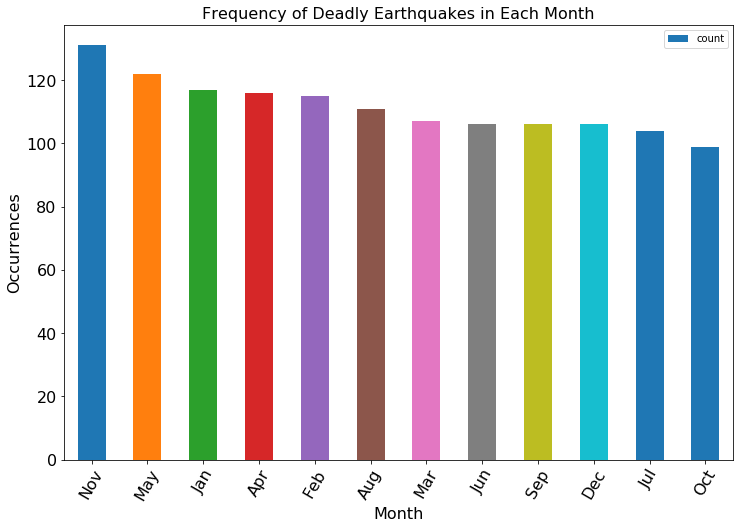

In [285]:
eq_month_total.plot(kind = 'bar', x = 'origin', y = 'count')
month_ticks = eq_month_total.index.values
month_list = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.xticks(month_ticks, month_list, rotation=60, fontsize = 16)
plt.yticks(fontsize = 16)
plt.title('Frequency of Deadly Earthquakes in Each Month', fontsize = 16)
plt.xlabel('Month', fontsize = 16)
plt.ylabel('Occurrences', fontsize = 16);

## The earthquakes seem to be pretty evenly distributed over the months of the year

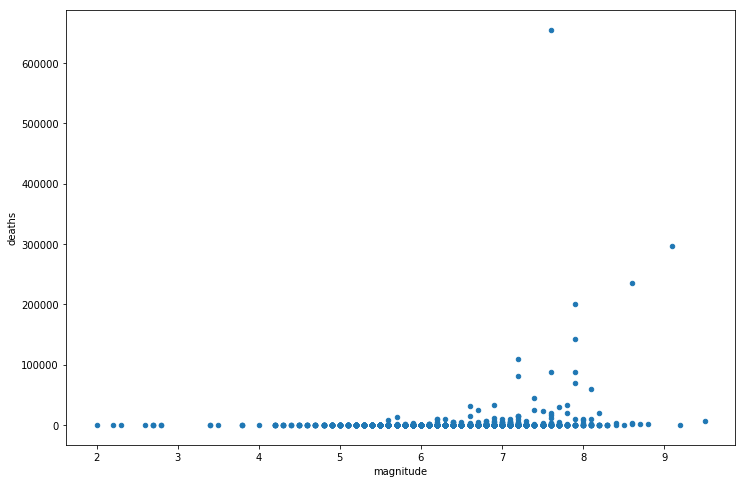

In [286]:
clean_df.plot(kind = 'scatter', x = 'magnitude', y = 'deaths')

In [287]:
countries = gpd.read_file('./Data/country_borders.geojson')
countries.head(1)

,scalerank,labelrank,sovereignt,sov_a3,adm0_dif,level,type,admin,adm0_a3,geou_dif,...,region_un,subregion,region_wb,name_len,long_len,abbrev_len,tiny,homepart,featureclass,geometry
0,1,3,Afghanistan,AFG,0,2,Sovereign country,Afghanistan,AFG,0,...,Asia,Southern Asia,South Asia,11,11,4,-99,1,Admin-0 country,"POLYGON ((61.21081709172574 35.65007233330923,..."


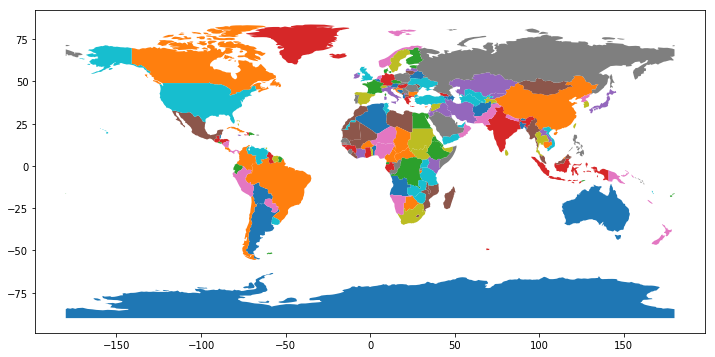

In [288]:
countries.plot(column = 'admin')

In [289]:
plate_bounds = gpd.read_file('./Data/tectonic_boundaries.geojson')
plate_bounds.head(1)

,cartodb_id,type,plateb,platea,source,name,layer,geometry
0,4,,AN,SO,Lemaux et al. [2002],SO-AN,plate boundary,"(LINESTRING (32.1258 -46.9998, 33.1739 -47.264..."


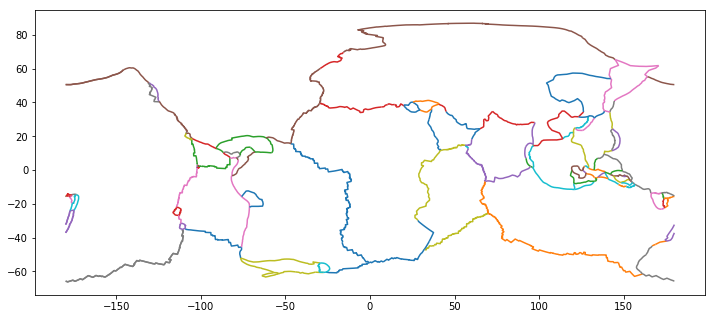

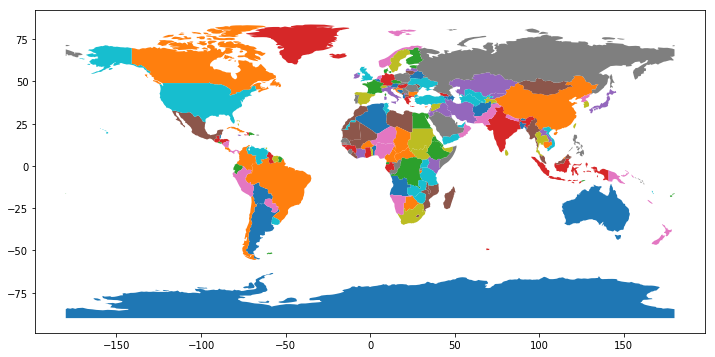

In [290]:
plate_bounds.plot(column = 'name')
countries.plot(column = 'admin')

In [299]:
# Creating a DF to map the points
# Dropping the rows with NaN for Lat and Long
map_df = clean_df
map_df = map_df.dropna(subset=['lat'])
map_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1325 entries, 0 to 1339
Data columns (total 14 columns):
origin               1325 non-null datetime64[ns]
country              1325 non-null object
lat                  1325 non-null float64
long                 1325 non-null float64
depth_km             1248 non-null object
magnitude            1324 non-null float64
secondary_effects    370 non-null object
pde_shaking          739 non-null float64
pde_total            749 non-null float64
utsu_total           1027 non-null float64
em_dat_total         559 non-null float64
other_source         27 non-null object
deaths               1243 non-null float64
geometry             1325 non-null object
dtypes: datetime64[ns](1), float64(8), object(5)
memory usage: 155.3+ KB


In [300]:
# GeoDataFrame of Clean DF
clean_geo = gpd.GeoDataFrame(map_df, crs = plate_bounds.crs, geometry = clean_df['geometry'])

In [301]:
# for row in clean_df.iterrows():
#     row_values = row[1]
#     print(row_values)

In [368]:
#create our map of Nashville and show it
map_world = folium.Map(location = [0,0], zoom_start = 2)

#draw our plate boundaries: plate_bounds
folium.GeoJson(plate_bounds).add_to(map_world)

#iterate through our urban art to create locations and markers for each piece
#here lat is listed first!!
#also the apostrophe in the 4th row causes problems!

for row in map_df.iterrows():
    row_values = row[1] 
    location = [row_values['lat'], row_values['long']]
    popup = 'Date: ' + str(row_values['origin']) + '<br/>' +  'Country: ' + str(row_values['country']) + '<br/>' + 'Magnitude: ' + str(row_values['magnitude'])+ '<br/>'+ 'Deaths: ' + str(row_values['deaths'])
    mag_radius = 4.5 ** row_values['magnitude'] 
    death_radius = row_values['deaths']  * 5
    #marker = folium.Marker(location = location, popup = popup)
    if row_values['magnitude'] > 5.5:
        marker = folium.Circle(location=location, popup=popup, radius=mag_radius, color='crimson', fill=False, fill_color='crimson').add_to(map_world)
        marker.add_to(map_world)
    if row_values['deaths'] > 10000:
        marker = folium.Circle(location=location, popup=popup, radius=death_radius, color='green', fill=False, fill_color='green').add_to(map_world)
        marker.add_to(map_world)

# Show map
map_world

In [356]:
map_hooray = folium.Map(location=[0, 0],
                    zoom_start = 2) 
#draw our plate boundaries: plate_bounds
folium.GeoJson(plate_bounds).add_to(map_hooray)

# # Ensure you're handing it floats
# df_acc['Latitude'] = df_acc['Latitude'].astype(float)
# df_acc['Longitude'] = df_acc['Longitude'].astype(float)

# Filter the DF for rows, then columns, then remove NaNs
heat_df = map_df[map_df['magnitude']>= 6] # Reducing data size so it runs faster
#heat_df = heat_df[heat_df['Year']=='2007'] # Reducing data size so it runs faster
heat_df = heat_df[['lat', 'long']]
#heat_df = heat_df.dropna(axis=0, subset=['Latitude','Longitude'])

# List comprehension to make out list of lists
heat_data = [[row['lat'],row['long']] for index, row in heat_df.iterrows()]

# Plot it on the map
HeatMap(heat_data).add_to(map_hooray)

# Display the map
map_hooray